In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import seaborn as sns
import gudhi as gd
from scipy.stats import norm

# Bivariate

In [18]:
np.random.seed(48823)

### Sampling From a PDF (Metropolis Hastings)

In [19]:
# Metropolis-Hastings sampler
def metropolis_hastings(unnormalized_density, n_samples, proposal_width=1):
    samples = np.zeros((n_samples, 2))
    current_x, current_y = np.random.randn(2)
    current_density = unnormalized_density(current_x, current_y)
    
    # Run the Markov chain
    for i in range(n_samples):
        proposed_x = current_x + proposal_width * np.random.randn()
        proposed_y = current_y + proposal_width * np.random.randn()
        proposed_density = unnormalized_density(proposed_x, proposed_y)
        
        acceptance_ratio = proposed_density / current_density
        
        if np.random.rand() < acceptance_ratio:
            current_x, current_y = proposed_x, proposed_y
            current_density = proposed_density
        
        samples[i] = [current_x, current_y]
    
    return samples

# Generate samples
def generate_samples(unnormalized_density, n_samples=10000, burn_in=1000, proposal_width=0.5):
    all_samples = metropolis_hastings(unnormalized_density, n_samples + burn_in, proposal_width)
    samples = all_samples[burn_in:]
    return samples

def visualize_results(unnormalized_density, samples):
    fig = plt.figure(figsize=(10, 6))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(samples[:, 0], samples[:, 1])
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Samples from the Distribution')
    ax1.set_aspect('equal')

    x = np.linspace(samples.min()-2, samples.max()+2, 100)
    y = np.linspace(samples.min()-2, samples.max()+2, 100)
    X, Y = np.meshgrid(x, y)
    Z = unnormalized_density(X, Y)

    ax3 = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax3.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('Density')
    ax3.set_title('Density Surface')

    plt.tight_layout()
    plt.show()

In [20]:
def annulus_pdf(x, y):
    r_squared = x**2 + y**2
    return np.exp(-(0.5 * r_squared**2 - 4.0 * r_squared))

annulus = generate_samples(annulus_pdf, n_samples=5000, burn_in=10000, proposal_width=1)

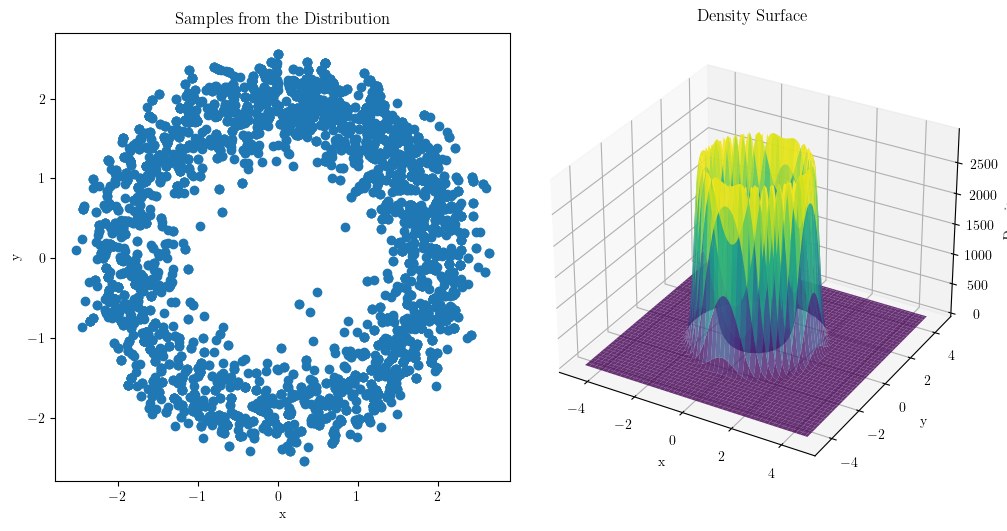

In [21]:
visualize_results(annulus_pdf, annulus)

In [22]:
def uniform_pdf(x, y, x_min=-3, x_max=3, y_min=-3, y_max=3):
    in_bounds = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    area = (x_max - x_min) * (y_max - y_min)
    density = np.where(in_bounds, 1 / area, 0)
    return density

uniform = generate_samples(uniform_pdf, n_samples=5000, burn_in=10000, proposal_width=1)

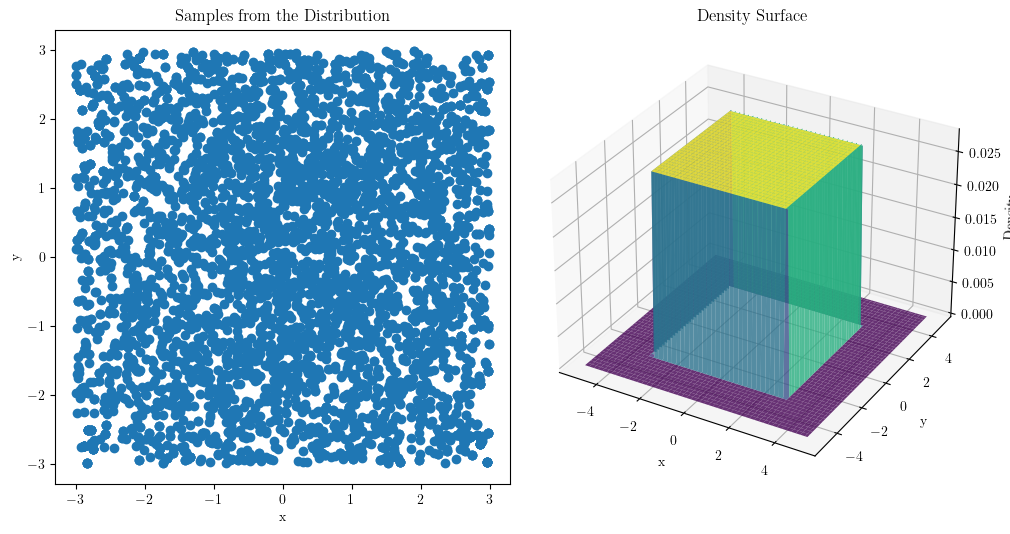

In [23]:
visualize_results(uniform_pdf, uniform)

In [24]:
def clusters_pdf(x, y):
    density = np.zeros_like(x)
    
    for cluster_mean in [[0, 0], [3, 3], [3, -1]]:
        cov = np.array([[0.5, 0], [0, 0.5]])         
        diff = np.stack([x, y], axis=-1) - cluster_mean
        inv_cov = np.linalg.inv(cov)
        exponent = np.einsum('...i,ij,...j->...', diff, inv_cov, diff)
        density += np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(cov))
    
    return density

clusters = generate_samples(clusters_pdf, n_samples=5000, burn_in=10000, proposal_width=3)

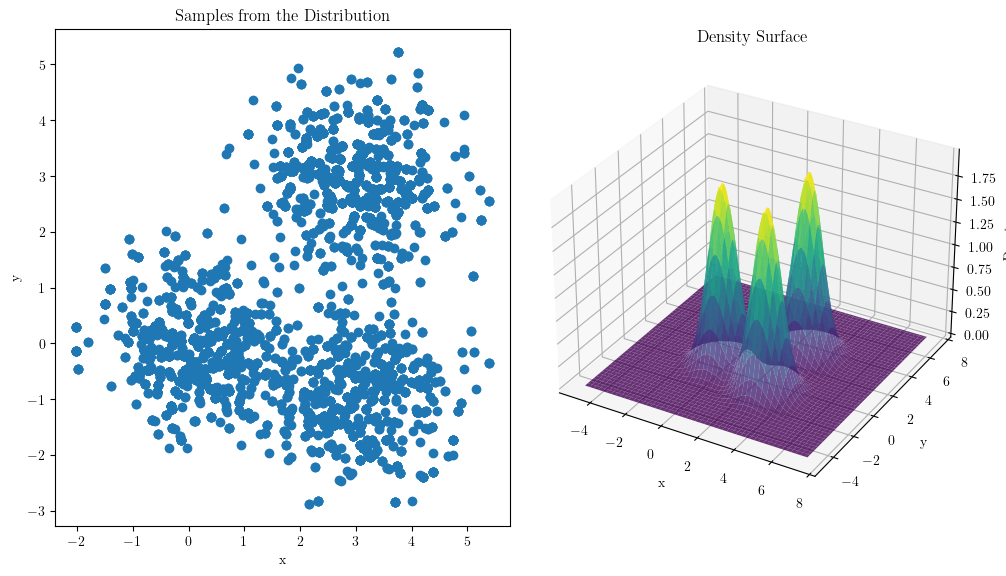

In [25]:
visualize_results(clusters_pdf, clusters)

In [26]:
names = {'uniform': uniform, 'annulus': annulus, 'clusters': clusters}

In [27]:
h_range = np.linspace(0.05, 0.75, 100)
grid_shape = (100, 100)

# Line Search Through all Bandwidths

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import gudhi.cubical_complex as cubical

def compute_cubical_persistence(density_values, grid_shape):
    density_values = density_values / density_values.max()
    function_values = np.array(density_values).reshape(grid_shape)
    cc = cubical.CubicalComplex(top_dimensional_cells=function_values)
    persistence = cc.persistence()
    return persistence

def topology_persistence(X, kde, grid_shape):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                 np.linspace(y_min, y_max, grid_shape[1]))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density_values = kde(positions)

    persistence = compute_cubical_persistence(density_values, grid_shape)
    return persistence

def topology_loss(persistence_diagram, lambda1=0.8):
    lifetimes = np.array([d[1][1] - d[1][0] for d in persistence_diagram if d[1][1] < np.inf])
    if len(lifetimes) == 0:
        return np.inf  # If no significant features, assign high cost
    
    feature_complexity = np.sum(-lifetimes)
    betti_numbers = len(lifetimes)
    
    return lambda1 * feature_complexity + (1 - lambda1) * betti_numbers

def optimize_bandwidth_topology(X, bandwidth_range, grid_shape):
    best_bandwidth = None
    best_loss = np.inf
    losses = []

    for bw in bandwidth_range:
        kde = gaussian_kde(X.T, bw_method=bw)
        pd = topology_persistence(X, kde, grid_shape)
        loss = topology_loss(pd)
        losses.append(loss)
        
        if loss < best_loss:
            best_loss = loss
            best_bandwidth = bw
    
    return best_bandwidth, losses

def plot_kde(X, kde, title, grid_shape, name):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                 np.linspace(y_min, y_max, grid_shape[1]))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density_values = kde(positions).reshape(grid_shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(x_grid, y_grid, density_values, cmap="viridis", levels=20)
    plt.scatter(X[:, 0], X[:, 1], s=5, color='white', alpha=0.3)
    plt.colorbar()
    plt.title(title)
    plt.xlabel(f"$x$")
    plt.ylabel(f"$y$")
    plt.show()

# Line Search but Early Stopping with Relative Change of stability_threshold

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import gudhi.cubical_complex as cubical

def topology_loss(persistence_diagram, lambda1=0.8):
    lifetimes = np.array([d[1][1] - d[1][0] for d in persistence_diagram if d[1][1] < np.inf])
    if len(lifetimes) == 0:
        return tf.constant(np.inf, dtype=tf.float32)
    lifetimes_tf = tf.constant(lifetimes, dtype=tf.float32)
    feature_complexity = tf.reduce_sum(-lifetimes_tf)
    betti_numbers = tf.cast(len(lifetimes), dtype=tf.float32)
    return lambda1 * feature_complexity + (1 - lambda1) * betti_numbers

def compute_cubical_persistence(density_values, grid_shape):
    density_values = density_values / density_values.max()
    function_values = np.array(density_values).reshape(grid_shape)
    cc = cubical.CubicalComplex(top_dimensional_cells=function_values)
    persistence = cc.persistence()
    return persistence

def kde_density_tf(X, x_grid, y_grid, bw):
    X_np = X.numpy()
    x_grid_np = x_grid.numpy().flatten()
    y_grid_np = y_grid.numpy().flatten()
    bw = bw.numpy()
    grid_points = np.vstack([x_grid_np, y_grid_np]).T

    kde = gaussian_kde(X_np.T, bw_method=bw)
    densities = kde(grid_points.T)
    return tf.convert_to_tensor(densities, dtype=tf.float32)

def optimize_bandwidth_topology_tf(X, bandwidth_range, grid_shape, stability_threshold=0.1):
    losses = []
    stable_bandwidth = None

    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                 np.linspace(y_min, y_max, grid_shape[1]))
    
    X_tf = tf.constant(X, dtype=tf.float32)
    x_grid_tf = tf.constant(x_grid, dtype=tf.float32)
    y_grid_tf = tf.constant(y_grid, dtype=tf.float32)

    for i, bw in enumerate(bandwidth_range):
        bw_tf = tf.constant(bw, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(bw_tf)
            density_values = kde_density_tf(X_tf, x_grid_tf, y_grid_tf, bw_tf)
            persistence = compute_cubical_persistence(density_values.numpy(), grid_shape)
            loss = topology_loss(persistence)

        losses.append(loss.numpy())

        if i > 1:
            change = abs(losses[-1] - losses[-2]) / abs(losses[-2]) if losses[-2] != 0 else 0
            if change < stability_threshold:
                if stable_bandwidth is None:
                    stable_bandwidth = bw
                    break

    if stable_bandwidth is None:
        stable_bandwidth = bandwidth_range[np.argmin(losses)]

    return stable_bandwidth, losses

def plot_kde(X, kde, title, grid_shape, name):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                 np.linspace(y_min, y_max, grid_shape[1]))
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
    density_values = kde(positions).reshape(grid_shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(x_grid, y_grid, density_values, cmap="viridis", levels=20)
    plt.scatter(X[:, 0], X[:, 1], s=5, color='white', alpha=0.3)  # Show data points
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=15)
    plt.title(title, fontsize=20)
    plt.xlabel(f"$x$", fontsize=20)
    plt.ylabel(f"$y$", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.savefig(f"kde_2d_{name}_{title[-5:]}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Run for All Distributions

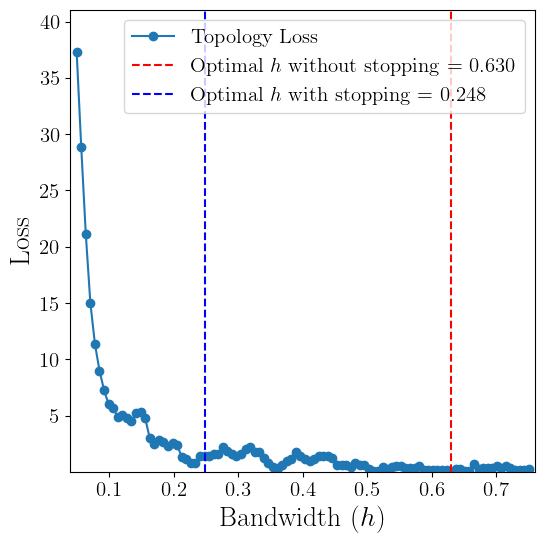

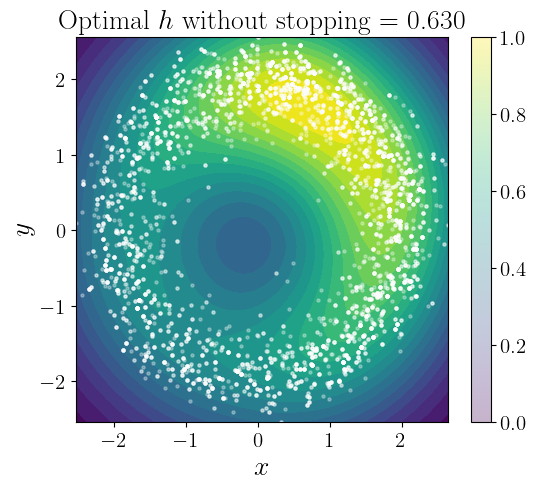

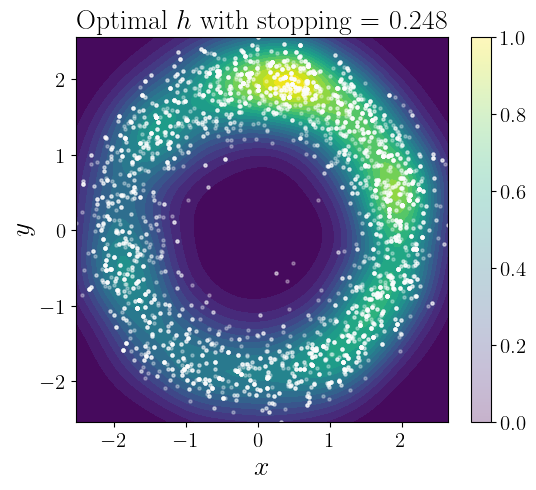

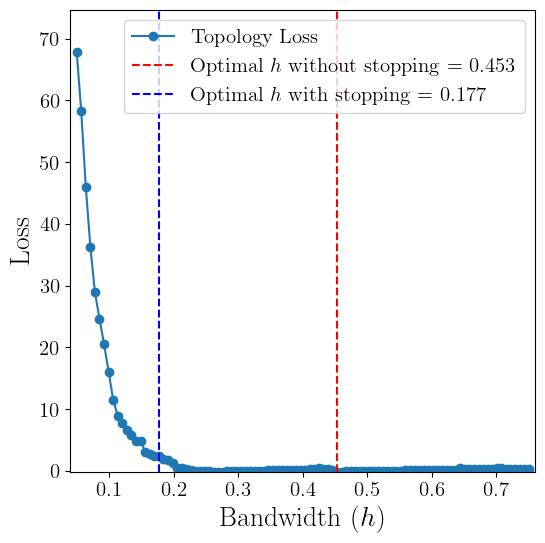

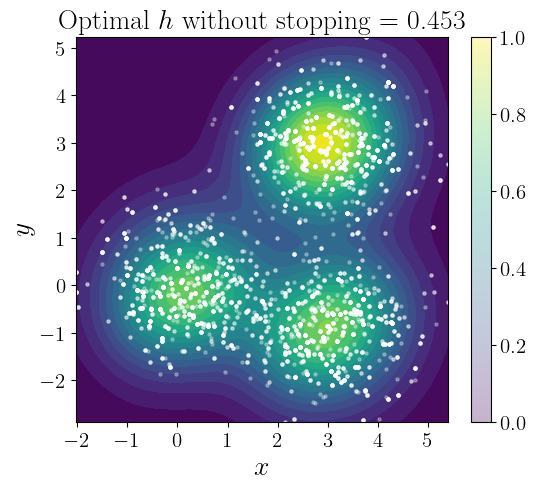

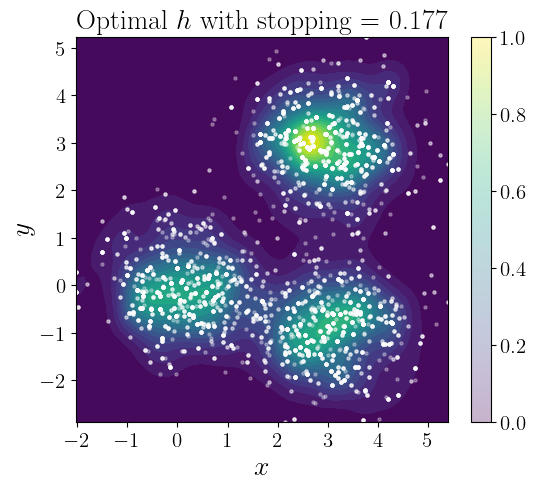

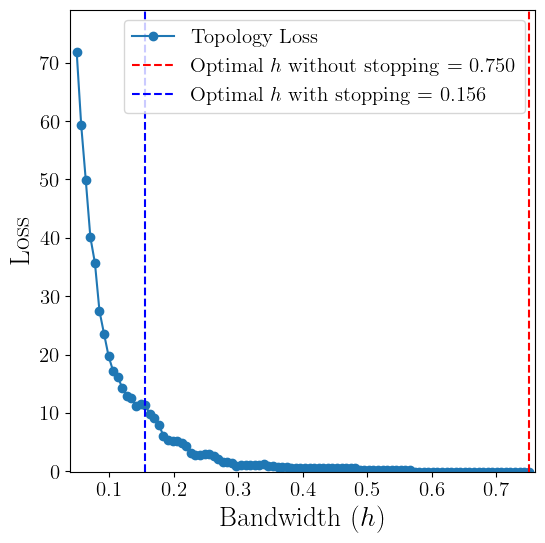

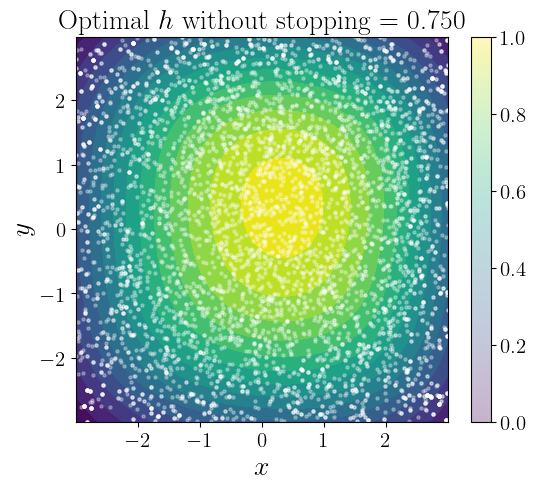

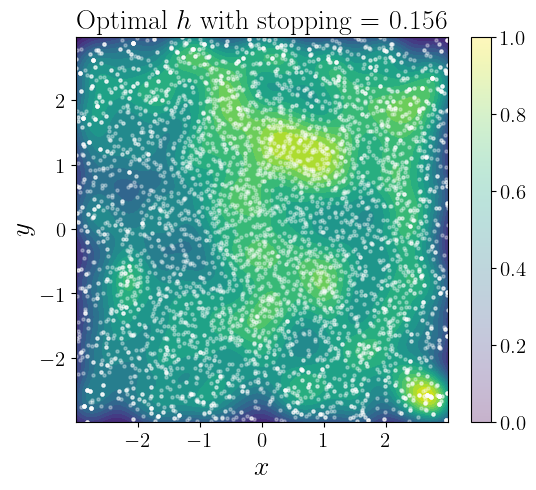

In [30]:
bw = {}
for name in ['annulus', 'clusters', 'uniform']:

    X_2D = names[name]

    best_bandwidth1, losses1 = optimize_bandwidth_topology(X_2D, h_range, grid_shape)

    # kde = gaussian_kde(X_2D.T, bw_method=best_bandwidth1)
    # plot_kde(X_2D, kde, f"KDE with Bandwidth = {best_bandwidth1:.3f}", grid_shape)
    # plt.figure(figsize=(5, 5))
    # plt.plot(h_range, losses, marker='o', label="Topology Loss")
    # plt.axvline(best_bandwidth1, color='r', linestyle='--', label=f"Optimal $h$ without stopping = {best_bandwidth1:.3f}")
    # plt.xlabel("Bandwidth (h)")
    # plt.ylabel("Topology-Based Loss")
    # plt.legend()
    # plt.show()

    best_bandwidth3, losses3 = optimize_bandwidth_topology_tf(X_2D, h_range, grid_shape, stability_threshold=0.01)

    plt.figure(figsize=(6, 6))
    plt.plot(h_range, losses1, marker='o', label="Topology Loss")
    plt.axvline(best_bandwidth1, color='r', linestyle='--', label=f"Optimal $h$ without stopping = {best_bandwidth1:.3f}")
    plt.axvline(best_bandwidth3, color='b', linestyle='--', label=f"Optimal $h$ with stopping = {best_bandwidth3:.3f}")
    plt.xlabel(f"Bandwidth ($h$)", fontsize=20)
    plt.ylabel(f"Loss", fontsize=20)
    plt.legend(fontsize=15, loc="upper right")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim(h_range[0]-0.01, h_range[-1]+0.01)
    plt.ylim(np.min(losses1) * 1.1, np.max(losses1) * 1.1)
    plt.savefig(f"loss_2d_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    kde = gaussian_kde(X_2D.T, bw_method=best_bandwidth1)
    plot_kde(X_2D, kde, f"Optimal $h$ without stopping = {best_bandwidth1:.3f}", grid_shape, name)
    kde = gaussian_kde(X_2D.T, bw_method=best_bandwidth3)
    plot_kde(X_2D, kde, f"Optimal $h$ with stopping = {best_bandwidth3:.3f}", grid_shape, name)

    bw[name] = best_bandwidth3

# KDE Comparison (Bivariate)

In [31]:
from scipy.stats import gaussian_kde
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

def normalize_pdf(pdf_true, x_grid, y_grid):
    dx = x_grid[0, 1] - x_grid[0, 0]
    dy = y_grid[1, 0] - y_grid[0, 0]
    d_area = dx * dy

    integral_true = np.sum(pdf_true) * d_area
    print(f"Integral of true PDF: {integral_true}")
    if integral_true > 0:
        pdf_true_normalized = pdf_true / integral_true
    else:
        pdf_true_normalized = np.zeros_like(pdf_true)

    return pdf_true_normalized

def kl_divergence_2d(pdf_true_normalized, kde_normalized, x_grid, y_grid):
    dx = x_grid[0, 1] - x_grid[0, 0]
    dy = y_grid[1, 0] - y_grid[0, 0]
    d_area = dx * dy
    kde_normalized = np.where(kde_normalized == 0, 1e-10, kde_normalized)
    kl_div_elements = np.where(pdf_true_normalized > 0,
                               pdf_true_normalized * np.log(pdf_true_normalized / kde_normalized),
                               0)
    kl_div = np.nansum(kl_div_elements) * d_area
    return kl_div

import ot
def earth_movers_distance(pdf1, pdf2, x, y):
    dx = x[0, 1] - x[0, 0]
    dy = y[1, 0] - y[0, 0]
    pdf1 = pdf1.flatten() / (np.sum(pdf1) * dx * dy)
    pdf2 = pdf2.flatten() / (np.sum(pdf2) * dx * dy)

    points = np.vstack([x.flatten(), y.flatten()]).T
    cost_matrix = ot.dist(points, points)
    wasserstein_dist = ot.emd2(pdf1, pdf2, cost_matrix, numItermax=10000)
    return wasserstein_dist

In [32]:
for name in ['annulus', 'clusters', 'uniform']:

    X_2D = names[name]
    best_bandwidth3 = bw[name]

    x_min, x_max = X_2D[:, 0].min(), X_2D[:, 0].max()
    y_min, y_max = X_2D[:, 1].min(), X_2D[:, 1].max()
    X, Y = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                    np.linspace(y_min, y_max, grid_shape[1]))
    positions = np.vstack([X.ravel(), Y.ravel()])

    ###############################

    pdf1 = gaussian_kde(X_2D.T, bw_method='scott')(positions)

    pdf2 = gaussian_kde(X_2D.T, bw_method='silverman')(positions)

    grid_search = GridSearchCV(KernelDensity(), {'bandwidth': h_range}, cv=5)
    grid_search.fit(X_2D)
    pdf3 = gaussian_kde(X_2D.T, bw_method=grid_search.best_params_['bandwidth'])(positions)

    ###############################

    top_pdf3 = gaussian_kde(X_2D.T, bw_method=best_bandwidth3)(positions)

    ###############################    

    Z_true = globals()[f'{name}_pdf'](X, Y)
    Z_true = normalize_pdf(Z_true, X, Y)

    Zs = [pdf1, pdf2, pdf3, top_pdf3]
    Zs = [Z.reshape(grid_shape) for Z in Zs]
    Zs = [normalize_pdf(Z, X, Y) for Z in Zs]
    Zs.append(Z_true)

    kdes = Zs

    klds = [kl_divergence_2d(Z_true, kdes[i], X, Y) for i in range(len(kdes))]

    print(f"KLD for each KDE in {name} case:")
    for i, ll in enumerate(klds):
        print(f"KLD {i}: {ll}")

    emds = [earth_movers_distance(Z_true, kdes[i], X, Y) for i in range(len(kdes))]

    print(f"EMD for each KDE in {name} case:")
    for i, ll in enumerate(emds):
        print(f"EMD {i}: {ll}")


Integral of true PDF: 23453.03511513408
Integral of true PDF: 0.9648096053380613
Integral of true PDF: 0.9648096053380613
Integral of true PDF: 0.991019279859265
Integral of true PDF: 0.9626096917295253
KLD for each KDE in annulus case:
KLD 0: 0.21093066452256465
KLD 1: 0.21093066452256465
KLD 2: 0.10899021815178649
KLD 3: 0.21831210847817129
KLD 4: 0.0


c:\Python311\Lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


EMD for each KDE in annulus case:
EMD 0: 238.24677285593927
EMD 1: 238.24677285593927
EMD 2: 148.17856787151308
EMD 3: 240.50015843759982
EMD 4: 3.3265013064969185e-15
Integral of true PDF: 18.809011658814796
Integral of true PDF: 0.9922672598826752
Integral of true PDF: 0.9922672598826752
Integral of true PDF: 0.9875787580847385
Integral of true PDF: 0.9947451247451589
KLD for each KDE in clusters case:
KLD 0: 0.06148748870953852
KLD 1: 0.06148748870953852
KLD 2: 0.098516387526601
KLD 3: 0.051270883219147474
KLD 4: 0.0


c:\Python311\Lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


EMD for each KDE in clusters case:
EMD 0: 63.10423866531582
EMD 1: 63.10423866531582
EMD 2: 69.2331643758688
EMD 3: 51.81282435217938
EMD 4: 2.1134355881207928e-15
Integral of true PDF: 1.0170778735856554
Integral of true PDF: 0.9001903643306812
Integral of true PDF: 0.9001903643306812
Integral of true PDF: 0.9349830916208131
Integral of true PDF: 0.93818514260872
KLD for each KDE in uniform case:
KLD 0: 0.029714000712725102
KLD 1: 0.029714000712725102
KLD 2: 0.029032899363447537
KLD 3: 0.029402997784917385
KLD 4: 0.0


c:\Python311\Lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


EMD for each KDE in uniform case:
EMD 0: 129.49211698351243
EMD 1: 129.49211698351243
EMD 2: 127.70244404431749
EMD 3: 128.50096738028873
EMD 4: 0.0


# Loop to Generate 5000 Simulations

In [ ]:
from datetime import datetime

In [ ]:
for i in range(5000):

    np.random.seed(int(datetime.now().timestamp()))

    annulus = generate_samples(annulus_pdf, n_samples=5000, burn_in=10000, proposal_width=1)
    uniform = generate_samples(uniform_pdf, n_samples=5000, burn_in=10000, proposal_width=1)
    clusters = generate_samples(clusters_pdf, n_samples=5000, burn_in=10000, proposal_width=3)

    filename = "annulus_{}.npy".format(i)
    np.save(filename, annulus, allow_pickle=True)
    filename = "uniform_{}.npy".format(i)
    np.save(filename, uniform, allow_pickle=True)
    filename = "clusters_{}.npy".format(i)
    np.save(filename, clusters, allow_pickle=True)

In [ ]:
h_range = np.linspace(0.05, 0.5, 100)
grid_shape = (100, 100)

for cat in ['annulus', 'clusters','uniform']:

    for i in range(5000):
        X_2D = np.load(f'{cat}_{i}.npy', allow_pickle=True)
        bw, losses = optimize_bandwidth_topology_tf(X_2D, h_range, grid_shape, stability_threshold=0.01)

        ##############################
        
        x_min, x_max = X_2D[:, 0].min(), X_2D[:, 0].max()
        y_min, y_max = X_2D[:, 1].min(), X_2D[:, 1].max()
        X, Y = np.meshgrid(np.linspace(x_min, x_max, grid_shape[0]), 
                                        np.linspace(y_min, y_max, grid_shape[1]))
        positions = np.vstack([X.ravel(), Y.ravel()])

        ###############################

        pdf1 = gaussian_kde(X_2D.T, bw_method='scott')(positions)

        pdf2 = gaussian_kde(X_2D.T, bw_method='silverman')(positions)

        grid_search = GridSearchCV(KernelDensity(), {'bandwidth': h_range}, cv=5)
        grid_search.fit(X_2D)
        pdf3 = gaussian_kde(X_2D.T, bw_method=grid_search.best_params_['bandwidth'])(positions)

        ################################

        top_pdf1 = gaussian_kde(X_2D.T, bw_method=bw)(positions)

        Z_true = globals()[f'{cat}_pdf'](X, Y)
        Z_true = normalize_pdf(Z_true, X, Y)

        Zs = [pdf1, pdf2, pdf3, top_pdf1]
        Zs = [Z.reshape(grid_shape) for Z in Zs]
        Zs = [normalize_pdf(Z, X, Y) for Z in Zs]
        Zs.append(Z_true)

        kdes = Zs

        klds = [kl_divergence_2d(Z_true, kdes[i], X, Y) for i in range(len(kdes))]
        emds = [earth_movers_distance(Z_true, kdes[i], X, Y) for i in range(len(kdes))]

        filename = "{}_KLD_{}.npy".format(cat, i)
        np.save(filename, np.array(klds), allow_pickle=True)
        filename = "{}_EMD_{}.npy".format(cat, i)
        np.save(filename, np.array(emds), allow_pickle=True)


In [ ]:
for cat in ['annulus', 'clusters','uniform']:

    klds = []
    emds = []
    for i in range(5000):

        filename = "{}_KLD_{}.npy".format(cat, i)
        klds.append(np.load(filename, allow_pickle=True))
        filename = "{}_EMD_{}.npy".format(cat, i)
        emds.append(np.load(filename, allow_pickle=True))

    klds = np.array(klds)
    emds = np.array(emds)

    print(np.mean(klds[~np.isinf(klds).any(axis=1)], axis=0))
    print(np.mean(emds[~np.isinf(emds).any(axis=1)], axis=0))

    print(np.std(klds[~np.isinf(klds).any(axis=1)], axis=0))
    print(np.std(emds[~np.isinf(emds).any(axis=1)], axis=0))